In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import pickle
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data analysis

In [31]:
bank = pd.read_csv("BankNote_Authentication.csv")
bank.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [32]:
bank.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

We see that there is no missing values.

In [33]:
for col in bank.columns:
    print("{}".format(bank[col].dtype))

float64
float64
float64
float64
int64


All the features are continuous.

In [34]:
bank.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


The features have different ranges.

In [35]:
bankh=bank.drop(["class"], axis=1)
bankh.head()

,variance,skewness,curtosis,entropy
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


<AxesSubplot:>

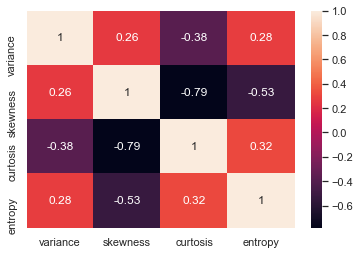

In [36]:
corr=bankh.corr()
sns.heatmap(corr, annot=True)

We see that there is very small correlations between the features.

In [37]:
def diagnostic(data, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    sns.distplot(data[variable])
    plt.subplot(1,3,2)
    stats.probplot(data[variable], dist="norm", plot=plt)
    plt.subplot(1,3,3)
    sns.boxplot(data[variable])

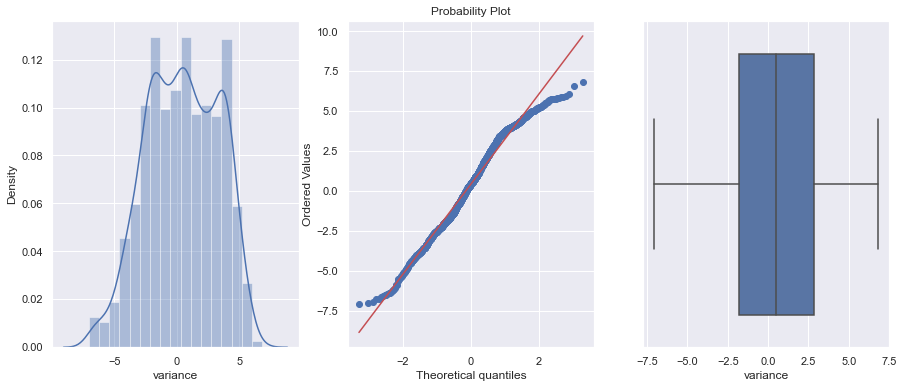

In [38]:
diagnostic(bank, "variance")

We see that from the figure above that the distribution of "variance"  is very close to the normal distribution  and has no outlier

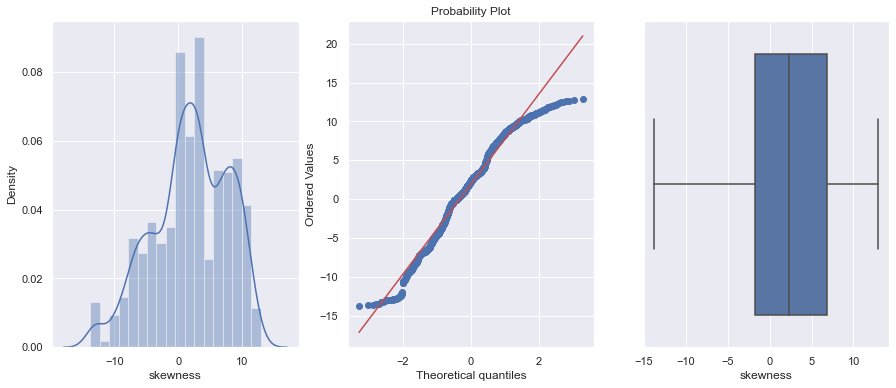

In [39]:
diagnostic(bank, "skewness")

We see that from the figure above that the distribution of "skewness"  is very close to the normal distribution  and has no outlier

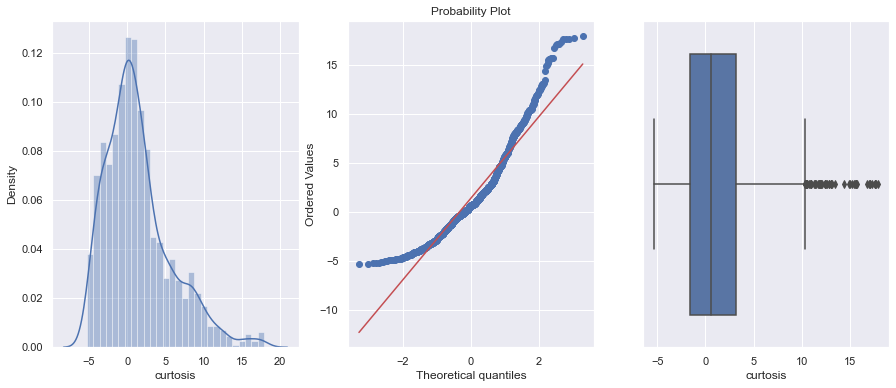

In [40]:
diagnostic(bank, "curtosis")

The distribution of "curtosis" is close to the normal distribution but has outliers.

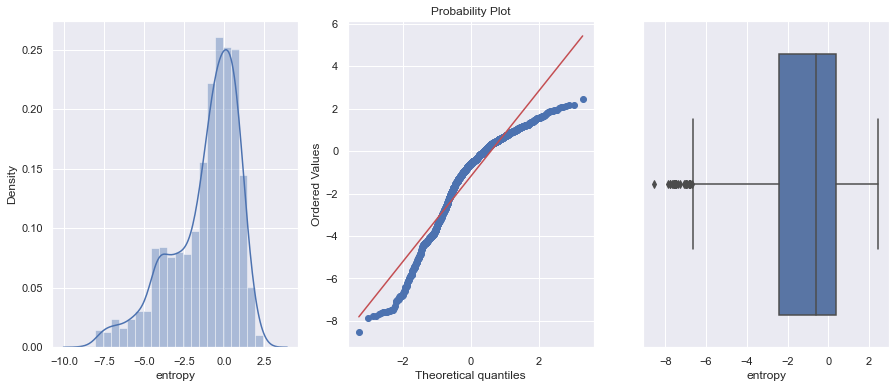

In [41]:
diagnostic(bank, "entropy")

The distribution of "entropy" is close to the normal distribution but has outliers, we will handle these outliers if the selected algorithm is sensitive to outliers.

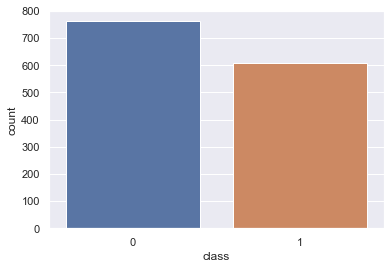

In [42]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="class", data=bank)

The result from the countplot shows that the dataset is balanced.

Let's handle the Outliers

In [43]:
x_train,x_test,y_train,y_test = train_test_split(bank.drop(["class"], axis=1), bank["class"],
                                                 test_size=0.2, random_state=0, stratify=bank["class"])

In [44]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [45]:
CU_upper_limit, CU_lower_limit = find_skewed_boundaries(x_train, 'curtosis', 1.5)
CU_upper_limit, CU_lower_limit

(10.71395, -8.88005)

In [46]:
EN_upper_limit, EN_lower_limit = find_skewed_boundaries(x_train, 'entropy', 1.5)
EN_upper_limit, EN_lower_limit

(4.307125, -6.1257150000000005)

In [47]:
x_train['curtosis']= np.where(x_train['curtosis'] > CU_upper_limit, CU_upper_limit,
                       np.where(x_train['curtosis'] < CU_lower_limit, CU_lower_limit, x_train['curtosis']))

x_test['curtosis']= np.where(x_test['curtosis'] > CU_upper_limit, CU_upper_limit,
                       np.where(x_test['curtosis'] < CU_lower_limit, CU_lower_limit, x_test['curtosis']))

In [48]:
x_train['entropy']= np.where(x_train['entropy'] > EN_upper_limit, EN_upper_limit,
                       np.where(x_train['entropy'] < EN_lower_limit, EN_lower_limit, x_train['entropy']))

x_test['entropy']= np.where(x_test['entropy'] > EN_upper_limit, EN_upper_limit,
                       np.where(x_test['entropy'] < EN_lower_limit, EN_lower_limit, x_test['entropy']))

# Model selection

In banknote authentication, if the model predicts that the banknote is authentic when it is not really authentic then this is not good when using the banknote (false posive increases). if the model predicts that the banknote is not authentic when it is really authentic then this is not good also because we will get rid off a real banknote (false  negative increases). So in this problem, i will try to decrease the false positives and the false negatives. So i will be using F1_score as a performance metric in this process of model selection. To compare the algorithms we will be using cross_val_score from sklearn.model_selection to see how well the model perform on the data.

Let's scale the data with StandardScaler

In [49]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_train = pd.DataFrame(x_train,columns=["variance", "skewness", "curtosis", "entropy"])

x_test = scale.transform(x_test)
x_test = pd.DataFrame(x_test,columns=["variance", "skewness", "curtosis", "entropy"])

Trying ten algorithms using cross_validate and select the best one 

In [50]:
train_score = dict()
test_score = dict()
def cross_vall_score(model, xtrain, ytrain, xtest, ytest):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    summary = cross_validate(model[1], xtrain, ytrain,cv=cv, scoring="f1", return_train_score=True, n_jobs=-1)
    train_score["{}".format(model[0])] = summary["train_score"].mean()
    test_score["{}".format(model[0])] = summary["test_score"].mean()

In [51]:
models = []
models.append(["LogisticRegression", LogisticRegression()])
models.append(["KNN", KNeighborsClassifier()])
models.append(["SVC", SVC()])
models.append(["RandomForestClassifier", RandomForestClassifier()])
models.append(["Naive Bayes", GaussianNB()])
models.append(["AdaBoostClassifier", AdaBoostClassifier()])
models.append(["GradientBoostingClassifier", GradientBoostingClassifier()])
models.append(["XGBClassifier", XGBClassifier()])
models.append(["LGBMClassifier", LGBMClassifier()])
models.append(["DecisionTreeClassifier", DecisionTreeClassifier()])

In [52]:
for i,model in enumerate(models):
    cross_vall_score(model, x_train, y_train, x_test, y_test)

In [53]:
testr_score = pd.DataFrame.from_dict(test_score,orient='index')

In [54]:
trainr_score = pd.DataFrame.from_dict(train_score,orient='index')

In [55]:
result = pd.concat([trainr_score, testr_score], axis=1)
result.columns=["train_score", "test_score"]
result

,train_score,test_score
LogisticRegression,0.977913,0.978033
KNN,0.997955,0.997980
SVC,1.000000,1.000000
RandomForestClassifier,1.000000,0.988825
Naive Bayes,0.809079,0.808297
AdaBoostClassifier,1.000000,0.993855
GradientBoostingClassifier,1.000000,0.993939
XGBClassifier,1.000000,0.992825
LGBMClassifier,1.000000,0.990802
DecisionTreeClassifier,1.000000,0.983713


From thes results of cross validation SVC shows a best result, let's select SVC and train it on the whole training set.

In [56]:
svm = SVC(random_state=0)
svm.fit(x_train, y_train)
train_pred = svm.predict(x_train)
test_pred = svm.predict(x_test)
print("training score:{}".format(f1_score(y_train, train_pred)))
print("testing score:{}".format(f1_score(y_test, test_pred)))

training score:1.0
testing score:1.0


The SVC classifier confirms its skills on training set.

Let's save the model.

In [57]:
model=pickle.dump(svm, open("svm_model.pkl", "wb"))